In [130]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST,FashionMNIST
#from visualization14 import ANN
#%matplotlib widget

In [131]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import copy

## For trained weights

In [132]:
import numpy as np
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.metrics.functional import accuracy
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST


class EmbeddingsCallback(Callback):
    def __init__(self):
        super().__init__()
        
    def on_test_end(self, trainer, pl_module):
        #pl_module.
        trainer.logger.experiment.add_embedding(
            pl_module.test_embeddings,#pl_module.
            pl_module.test_targets,
            global_step=trainer.global_step)
        


class ANN(pl.LightningModule):
    def __init__(self,dataset_val1, data_dir='./'):
        super().__init__()
        # Set our init args as class attributes
        self.data_dir = data_dir
        self.test_targets = []
        self.test_embeddings = torch.zeros((0, 50),
                                           dtype=torch.float32,
                                           device='cpu')
        self.test_predictions = []
        
        self.dataset_train=[]
        self.dataset_val=dataset_val1
        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(2)
        
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128,50)
        self.fc3 = nn.Linear(50, self.num_classes)
        # Define PyTorch model

    def forward(self, x):
        batch_size,channles,width,highet= x.size()
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.maxpool1(x))
        
        batch_size,channles,width,highet= x.size()
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.maxpool2(x))
        
        batch_size,channles,width,highet= x.size()
        
        x = x.view(-1, 64 * 5 *5)
        x = self.fc1(x)
        x = self.fc2(x)
        y = self.fc3(F.relu(x))
        return x, y

    def training_step(self, batch, batch_idx):
        x, y = batch
        _, logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        _, logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        x, y = batch
        embeddings, logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.test_predictions.extend(preds.detach().cpu().tolist())
        self.test_targets.extend(y.detach().cpu().tolist())
        self.test_embeddings = torch.cat((self.test_embeddings, embeddings), 0)
        self.log('test_acc', acc)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        print('')

    def setup(self, dataset_train1,dataset_test1=[],dataset_val1=[], stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit':
            self.dataset_train, self.dataset_val,self.dataset_test=dataset_train1,dataset_val1,dataset_test1
           
        print(len(self.dataset_train))
        if stage == 'test':
            self.dataset_test = dataset_test1
                                  

    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=32, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=32)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=32)


# Select Randomly 200 points to start AL training 

In [133]:
if __name__ == "__main__":
    
    data_dir='./'
    # download
    MNIST(data_dir, train=True, download=True)
    MNIST(data_dir, train=False, download=True)
    transform = transforms.Compose([transforms.ToTensor()])
    dataset_full = MNIST(data_dir,train=True,transform=transform)
            
    dataset_train, dataset_val,remaining = random_split(dataset_full, [200, 10000,49800])
    dataset_train_original=copy.deepcopy(dataset_train)


    model = ANN(dataset_val)
    model.setup(dataset_train,dataset_val,stage='fit')
    model.dataset_val=dataset_val
    embedding_callback = EmbeddingsCallback()
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        filename='mnist-{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        save_weights_only=True)
    trainer = pl.Trainer(
                         max_epochs=30,
                         progress_bar_refresh_rate=10,
                         callbacks=[checkpoint_callback, embedding_callback])#gpus=1,
    trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


200

200



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Shows some of MNIST data

In [134]:
import itertools
batch_size = 2
sample_at = 5
k = int(np.floor(sample_at/batch_size))

tensor([9, 8, 0, 9, 6, 7, 5, 7, 8, 4, 7, 0, 3, 4, 8, 6, 8, 2, 2, 5, 7, 5, 1, 0,
        7, 6, 9, 3, 7, 1, 9, 8])


C:\Users\USER\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
C:\Users\USER\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


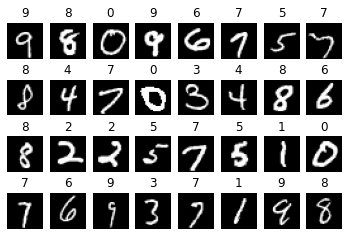

In [135]:
import itertools
k = int(np.floor(sample_at/batch_size))
transform = transforms.Compose([transforms.ToTensor()])
#data = MNIST(".", train=False, download=True, transform=transform)
data=copy.deepcopy(dataset_train)
dataloader = DataLoader(data, batch_size=32)
my_sample = next(itertools.islice(dataloader, k, None))
print (my_sample[1])

plt.figure()
for i in range(32):
    plt.subplot(4,8,i+1)
    arr=np.squeeze(data)
    plt.imshow(my_sample[0][i][0], cmap='gray')
    plt.axis('off')
    plt.title(my_sample[1][i].item())

#dataloader = DataLoader(data, batch_size=32)

## prepare_test_embeddings

In [136]:
def prepare_test_embeddings(dataset_train):
    #transform = transforms.Compose([transforms.ToTensor()])
    #data=dataset_train
    dataloader = DataLoader(dataset_train, batch_size=32)
    #test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
    test_predictions = []
    test_targets = []
    test_embeddings = torch.zeros((0, 50), dtype=torch.float32)
    for x,y in dataloader:
        #x = x.cpu()
        embeddings, logits = model(x)
        preds = torch.argmax(logits, dim=1)
        test_predictions.extend(preds)#.detach().cpu().tolist())
        test_targets.extend(y)#.detach().cpu().tolist())
        test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
        #test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
    #test_imgs = np.array(test_imgs)
    test_embeddings = np.array(test_embeddings)
    test_targets = np.array(test_targets)
    test_predictions = np.array(test_predictions)
    
    test_acc = np.sum(test_predictions == test_targets)
    final_test_acc = test_acc/len(test_embeddings)
    
    return test_embeddings,test_targets,test_predictions,final_test_acc
#test_embeddings,test_targets,final_test_acc=prepare_test_embeddings(dataset_train)

In [137]:
data_test = MNIST(".", train=False, download=True, transform=transform)
_,_,_,final_test_acc=prepare_test_embeddings(data_test)
print('Initial Testing accuracy:  ',final_test_acc)

Initial Testing accuracy:   0.9076


# Kmeans ++

In [138]:
def all_list(test_embeddings,test_targets,data):
    test_embeddings=test_embeddings
    test_targets=test_targets
    list1,data1=[],[]
    list2,data2=[],[]
    list3,data3=[],[]
    list4,data4=[],[]
    list5,data5=[],[]
    list6,data6=[],[]
    list7,data7=[],[]
    list8,data8=[],[]
    list9,data9=[],[]
    list10,data10=[],[]
    i=0
    for embeddings in test_embeddings:
        if test_targets[i]==0:
            list1.append(embeddings)
            data1.append(data[i])
        if test_targets[i]==1:
            list2.append(embeddings)
            data2.append(data[i])
        if test_targets[i]==2:
            list3.append(embeddings)
            data3.append(data[i])
        if test_targets[i]==3:
            list4.append(embeddings)
            data4.append(data[i])
        if test_targets[i]==4:
            list5.append(embeddings)
            data5.append(data[i])
        if test_targets[i]==5:
            list6.append(embeddings)
            data6.append(data[i])
        if test_targets[i]==6:
            list7.append(embeddings)
            data7.append(data[i])
        if test_targets[i]==7:
            list8.append(embeddings)
            data8.append(data[i])
        if test_targets[i]==8:
            list9.append(embeddings)
            data9.append(data[i])
        if test_targets[i]==9:
            list10.append(embeddings)
            data10.append(data[i])
        i=i+1
    all_lists=[]
    all_data=[]
    list1,data1=np.array(list1),np.array(data1)
    all_lists.append(list1),all_data.append(data1)
    
    list2,data2=np.array(list2),np.array(data2)
    all_lists.append(list2),all_data.append(data2)
    
    list3,data3=np.array(list3),np.array(data3)
    all_lists.append(list3),all_data.append(data3)
    
    list4,data4=np.array(list4),np.array(data4)
    all_lists.append(list4),all_data.append(data4)
    
    list5,data5=np.array(list5),np.array(data5)
    all_lists.append(list5),all_data.append(data5)
    
    list6,data6=np.array(list6),np.array(data6)
    all_lists.append(list6),all_data.append(data6)
    
    list7,data7=np.array(list7),np.array(data7)
    all_lists.append(list7),all_data.append(data7)
    
    list8,data8=np.array(list8),np.array(data8)
    all_lists.append(list8),all_data.append(data8)
    
    list9,data9=np.array(list9),np.array(data9)
    all_lists.append(list9),all_data.append(data9)
    
    list10,data10=np.array(list10),np.array(data10)
    all_lists.append(list10),all_data.append(data10)
    
    print(list10.shape, len(list9),len(all_lists))
    return all_lists,all_data
#all_lists=all_list(test_embeddings2,test_targets2)
#all_lists=all_list(all_np,labels)

Prepare test embeddings for all data  

# extract embeddings of 200 training data to get the center points

In [139]:
len(dataset_train)

200

In [140]:
dataset_full2, remaning = random_split(dataset_train, [len(dataset_train),0])

In [141]:
test_embeddings,test_targets,test_predictions,final_test_acc=prepare_test_embeddings(dataset_train)

In [142]:
temb_test_embeddings_copy=test_embeddings
dataset_full2_copy=dataset_full2
test_targets_copy=test_targets
test_predictions_copy=test_predictions

# visualize the ditribution of Random 200 points 

In [143]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.003s...
[t-SNE] Computed neighbors for 200 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 12.453344
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.955406
[t-SNE] KL divergence after 1000 iterations: 0.211307


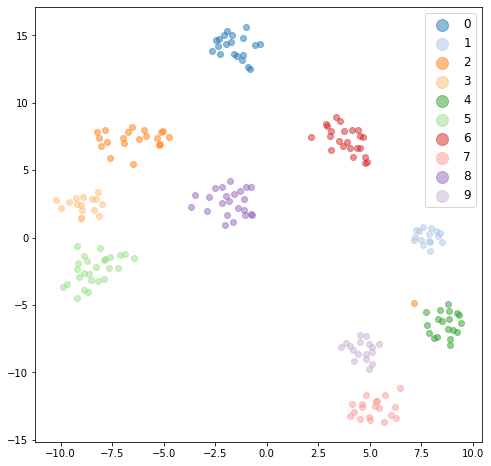

In [144]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# To Get only the correct data prediction  

In [145]:
def get_correct_embeddings(temb_test_embeddings_copy,dataset_full2_copy,test_targets_copy,test_predictions_copy):
    c=0
    print(len(temb_test_embeddings_copy))
    for i in range(len(temb_test_embeddings_copy)):
        try:
            if test_targets_copy[i]!=test_predictions_copy[i]:
                print(i)
                temb_test_embeddings_copy=np.delete(temb_test_embeddings_copy,i-c,axis=0)
                dataset_full2_copy=np.delete(dataset_full2_copy,i-c,axis=0)
                test_targets_copy=np.delete(test_targets_copy,i-c,axis=0)
                test_predictions_copy=np.delete(test_predictions_copy,i-c,axis=0)
                c=c+1
        except:
            print("")
    print(len(temb_test_embeddings_copy))
    return temb_test_embeddings_copy,dataset_full2_copy,test_targets_copy,test_predictions_copy
print(len(temb_test_embeddings_copy))

200


In [146]:
test_embeddings=temb_test_embeddings_copy
dataset_full2=dataset_full2_copy
test_targets=test_targets_copy
dataset_train_original2=dataset_full2

In [147]:
all_lists,all_data_points=all_list(test_embeddings,test_targets,dataset_full2)

(17, 50) 23 10


<ipython-input-138-3f24519255a4>:49: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  list1,data1=np.array(list1),np.array(data1)
<ipython-input-138-3f24519255a4>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  list1,data1=np.array(list1),np.array(data1)
<ipython-input-138-3f24519255a4>:52: FutureWarning: The input object of type 'Tensor' is an array-like implementin

In [148]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [149]:
kmeans = KMeans(n_clusters = 10)
kmeans.fit(test_embeddings) 
kmeans.labels_

array([2, 3, 9, 2, 4, 5, 5, 7, 0, 7, 3, 6, 3, 2, 9, 2, 3, 3, 4, 3, 9, 9,
       1, 3, 9, 1, 1, 4, 3, 0, 8, 0, 7, 1, 4, 1, 1, 6, 3, 6, 1, 3, 6, 3,
       8, 4, 0, 0, 4, 2, 8, 8, 1, 0, 8, 7, 3, 4, 2, 7, 1, 4, 1, 4, 9, 2,
       4, 9, 1, 0, 3, 0, 2, 6, 0, 4, 7, 6, 2, 1, 2, 8, 8, 3, 0, 3, 5, 4,
       0, 1, 9, 7, 0, 5, 9, 2, 6, 5, 1, 8, 5, 6, 7, 3, 2, 0, 6, 0, 5, 4,
       5, 8, 7, 2, 4, 8, 5, 8, 6, 2, 5, 2, 5, 4, 9, 9, 8, 5, 9, 1, 8, 3,
       7, 2, 9, 6, 6, 8, 2, 6, 5, 5, 0, 7, 2, 3, 1, 4, 8, 3, 1, 4, 4, 3,
       1, 1, 8, 6, 5, 1, 1, 0, 3, 0, 7, 8, 8, 3, 8, 7, 6, 5, 3, 2, 9, 9,
       7, 1, 7, 6, 8, 6, 6, 3, 6, 4, 2, 3, 1, 9, 9, 7, 3, 6, 2, 2, 0, 2,
       0, 4])

In [150]:
len(kmeans.cluster_centers_)

10

In [151]:
all_clusters=kmeans.cluster_centers_

In [152]:
import math
import scipy.spatial as sp
import numpy as np
def get_dist(a,b):
    reslt=sp.distance.cosine(a,b)
    return reslt

In [153]:
len(test_embeddings)

200

# assign center point for each class 

In [154]:
center_classes=[]
for clas in all_lists:
    for cluster in all_clusters:
        p=cluster
        n = len(clas)
        dist = math.inf #(infinity)
        temb_test_embeddings=clas#.copy()
        for i in range(n):
            d = get_dist(p,temb_test_embeddings[i])
            if d<dist and d!=0: # to avoid the same point
                dist =d
                np1= temb_test_embeddings[i]
    center_classes.append(np1)
    indx=np.where(all_clusters==cluster)
    all_clusters=np.delete(all_clusters,indx[0][0],axis=0)
    print(len(all_clusters))
len(center_classes)

9
8
7
6
5
4
3
2
1
0


10

# get 10 neighbours for each class to perform (200 initial points)

In [155]:
points_class0=[]
points_class1=[]
points_class2=[]
points_class3=[]
points_class4=[]
points_class5=[]
points_class6=[]
points_class7=[]
points_class8=[]
points_class9=[]
all_points=[]
all_points.append(points_class0)
all_points.append(points_class1)
all_points.append(points_class2)
all_points.append(points_class3)
all_points.append(points_class4)
all_points.append(points_class5)
all_points.append(points_class6)
all_points.append(points_class7)
all_points.append(points_class8)
all_points.append(points_class9)


points_dist0=[]
points_dist1=[]
points_dist2=[]
points_dist3=[]
points_dist4=[]
points_dist5=[]
points_dist6=[]
points_dist7=[]
points_dist8=[]
points_dist9=[]
all_dist=[]
all_dist.append(points_dist0)
all_dist.append(points_dist1)
all_dist.append(points_dist2)
all_dist.append(points_dist3)
all_dist.append(points_dist4)
all_dist.append(points_dist5)
all_dist.append(points_dist6)
all_dist.append(points_dist7)
all_dist.append(points_dist8)
all_dist.append(points_dist9)

In [156]:
all_np=[]
for lab in range(10):
    p=center_classes[lab]
    n = len(all_lists[lab])
    dist = math.inf #(infinity)
    temb_test_embeddings=all_lists[lab]#kmeans.labels_
    for c in range(10): 
        n = len(temb_test_embeddings)
        dist = math.inf
        for i in range(n):
            d = get_dist(p,temb_test_embeddings[i])
            if d<dist and d!=0: # to avoid the same point
                dist =d
                np1= temb_test_embeddings[i]
        all_np.append(np1)
        indx=np.where(temb_test_embeddings==np1)
        print(len(temb_test_embeddings))
        try:
            temb_test_embeddings=np.delete(temb_test_embeddings,indx[0][0],axis=0)
            dataset_train_original2=np.delete(dataset_train_original2,indx[0][0],axis=0)
        except:
            print('No Point')
        
    n = len(temb_test_embeddings)
    dist = math.inf
    for i in range(n):
        d = get_dist(p,temb_test_embeddings[i])
        all_points[lab].append(all_data_points[lab][i])
        all_dist[lab].append(d)
len(all_np)

20
19
18
17
16
15
14
13
12
11
16
15
14
13
12
11
10
9
8
7
21
20
19
18
17
16
15
14


C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


13
12
16
15
14
13
12
11
10
9
8
7
19
18
17
16
15
14
13
12
11
10
26
25
24
23
22
21
20
19
18
17
23
22
21
20
19
18
17
16
15
14
19
18
17
16
15
14
13
12
11
10
23
22
21
20
19
18
17
16
15
14
17
16
15
14
13
12
11
10
9
8


100

# get the original images (as core_data) corrosponding to the 100 center points

In [157]:
indx=np.where(test_embeddings==all_np[0])
core_data1=dataset_full2[indx[0][0]]
core_data1,t=random_split([core_data1],[1,0])
core_data1=tuple(core_data1)
for point in all_np[1:]: 
    indx=np.where(test_embeddings==point)
    arr=dataset_full2[indx[0][0]]
    arr,t=random_split([arr],[1,0])
    arr=tuple(arr)
    core_data1=torch.utils.data.ConcatDataset([arr,core_data1])

In [158]:
core_data=core_data1
len(core_data)

100

# Embeddings of 100 core-set (Just to visualization)

In [159]:
test_embeddings2,test_targets2,test_predictions2,final_test_acc2=prepare_test_embeddings(core_data)

In [160]:
test_embeddings2,core_data,test_targets2,test_predictions2=get_correct_embeddings(test_embeddings2,core_data,test_targets2,test_predictions2)

100
100


# visualize the ditribution of 100 core_data 

In [161]:
tsne = TSNE(2, verbose=1)
tsne_proj_core = tsne.fit_transform(test_embeddings2)
#tsne_proj = tsne.fit_transform(core_data.datasets[1])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 6.108237
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.958130
[t-SNE] KL divergence after 1000 iterations: 0.246796


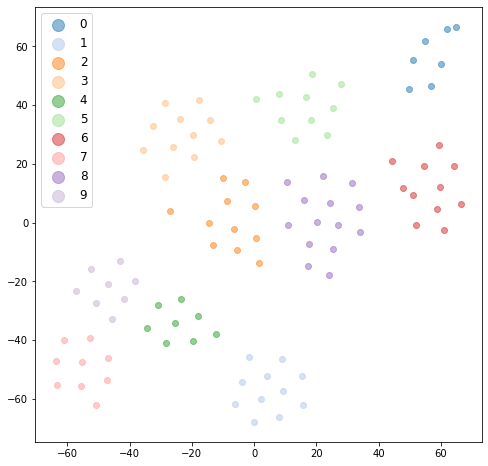

In [162]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_targets2==lab
    ax.scatter(tsne_proj_core[indices,0],tsne_proj_core[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

### **For one class SVM**

In [163]:
all_lists,_=all_list(test_embeddings2,test_targets2,core_data)

(8, 50) 14 10


<ipython-input-138-3f24519255a4>:49: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  list1,data1=np.array(list1),np.array(data1)
<ipython-input-138-3f24519255a4>:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  list1,data1=np.array(list1),np.array(data1)
<ipython-input-138-3f24519255a4>:52: FutureWarning: The input object of type 'Tensor' is an array-like implementin

In [164]:
X_train=np.concatenate((all_lists[9],all_lists[8],all_lists[7],all_lists[6],all_lists[5],all_lists[4],all_lists[3],all_lists[2],all_lists[1],all_lists[0]),axis=0)
len(X_train)

100

In [165]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.05, kernel = 'rbf', gamma = 'scale').fit(X_train)

In [166]:
def do_predict(dataset_test):
    #transform = transforms.Compose([transforms.ToTensor()])
    #data=dataset_train
    dataloader = DataLoader(dataset_test, batch_size=32)
    #test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
    test_predictions = []
    test_targets = []
    test_embeddings = torch.zeros((0, 50), dtype=torch.float32)
    for x,y in dataloader:
        #x = x.cpu()
        embeddings, logits = model(x)
        preds = torch.argmax(logits, dim=1)
        test_predictions.extend(preds)#.detach().cpu().tolist())
        test_targets.extend(y)#.detach().cpu().tolist())
        test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
        #test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
    #test_imgs = np.array(test_imgs)
    test_embeddings = np.array(test_embeddings)
    test_targets = np.array(test_targets)
    test_predictions = np.array(test_predictions)
    
    test_acc = np.sum(test_predictions == test_targets)
    final_test_acc = test_acc/len(test_embeddings)
    return final_test_acc,test_targets,test_embeddings

In [167]:
dataset_full2 = tuple([tuple(e) for e in dataset_full2])
len(dataset_full2)

200

# Just to visualize outlier prediction (Take one example)

In [168]:
dd1,remaning = random_split(dataset_full2, [100,len(dataset_full2)-100])
# do prediction 
_,t_targets3,t_embeddings3=do_predict(dd1)

In [169]:
len(dd1)

100

In [170]:
prediction = one_class_svm.predict(t_embeddings3)
prediction = [1 if i==-1 else 0 for i in prediction]

In [171]:
all_prediction=prediction

# to extract prediction by one svm 

In [172]:
def extract_prediction_by_svm(embedding):
    all_prediction=[]
    prediction2=one_class_svm.predict(embedding)
    prediction2 = [1 if i==-1 else 0 for i in prediction2]
    len(prediction2)
    return prediction2#,alldata

# to extract outliers (exact images)from the corosponding all_prediction  

In [173]:
all_outliers=torch.utils.data.Subset([],[])

In [174]:
def extract_outliers_from_svm(all_prediction,alldata):
    all_outliers=torch.utils.data.ConcatDataset([[],[]])
   
    out1=torch.utils.data.ConcatDataset([[],[]])
    for i in range(len(all_prediction)):
        if all_prediction[i]==1:
            out1=torch.utils.data.ConcatDataset([[(alldata[i][0],alldata[i][1])],out1])
    arr,t=random_split(out1,[len(out1),0])
    all_outliers=torch.utils.data.ConcatDataset([arr,all_outliers])  
    print(len(all_outliers))
    return all_outliers
temb_training=extract_outliers_from_svm(all_prediction,dd1)

5


In [175]:
temb_training

# visualization of OneSvm 

In [176]:
core_data=tuple([tuple(e) for e in core_data])

In [177]:
temb_training=torch.utils.data.ConcatDataset([core_data,temb_training])#core_data
test_embeddings4,test_targets4,_,_=prepare_test_embeddings(temb_training)
print(len(test_embeddings4))

105


In [178]:
#do predict on one SVM
prediction2 = one_class_svm.predict(test_embeddings4)
# Change the anomalies' values to make it consistent with the true values
prediction2 = [1 if i==-1 else 0 for i in prediction2]
#print("The result of outlier is ",prediction)

In [179]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings4)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 105 samples in 0.001s...
[t-SNE] Computed neighbors for 105 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 105 / 105
[t-SNE] Mean sigma: 6.248192
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.961132
[t-SNE] KL divergence after 1000 iterations: 0.217832


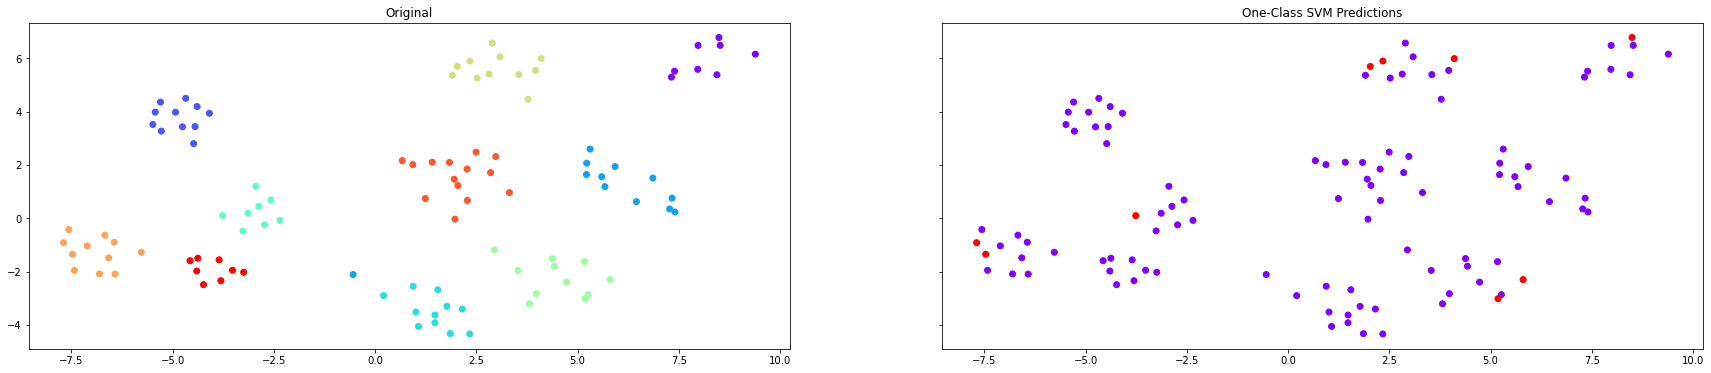

In [180]:
# Put the testing dataset and predictions in the same dataframe
df_test = pd.DataFrame(tsne_proj, columns=['feature1', 'feature2'])
df_test['y_test'] = test_targets4#test_targets4
df_test['one_class_svm_prediction'] = prediction2


df_core = pd.DataFrame(tsne_proj_core, columns=['feature1', 'feature2'])
df_core['y_test'] = test_targets2

fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(30,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow')
# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction'], cmap='rainbow')


In [181]:
data_test = MNIST(".", train=False, download=True, transform=transform)

In [182]:
len(model.dataset_train)

200

In [183]:
_,_,_,final_test_acc=prepare_test_embeddings(data_test)

In [184]:
final_test_acc

0.9076

In [185]:
dataset_full2_copy=remaining
dataset_train=dataset_train_original#core_data

# give an outlier score for all 49800 unlabeled training data and then take the highest 100 points in each round

In [186]:
remaining=dataset_full2_copy
dataset_train=dataset_train_original

In [187]:
import time
start_time = time.time()
CNN_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0 seconds ---


In [188]:
pred_list_val=[]
pred_list_train=[]
pred_list_test=[]
all_outliers=[]
len_outliers=[]
Times=[]

In [189]:
_,_,_,final_test_acc=prepare_test_embeddings(data_test)
pred_list_test.append(final_test_acc)

In [190]:
pred_list_val.append(trainer.callback_metrics["val_acc"])
pred_list_train.append(trainer.callback_metrics["train_acc"])
pred_list_test.append(final_test_acc)
Times.append(CNN_time)
len_outliers.append(200)

In [191]:
one_class_svm = OneClassSVM(nu=0.00005, kernel = 'poly', gamma ='auto').fit(test_embeddings)

In [192]:
kernel = 'poly'
gamma = 'auto'
NU=0.00001

roud=0
nu_out=100
while final_test_acc<0.97:
#for c in range(2):
    start_time = time.time()
    #one_class_svm = OneClassSVM(nu=0.5, kernel = 'rbf', gamma = 'scale').fit(X_train)
    _,_,test_embeddings=do_predict(remaining)
    whole_prediction=one_class_svm.predict(test_embeddings)
    Scores=one_class_svm.score_samples(test_embeddings)
    len_out=0
    for out1 in whole_prediction:
        if out1==1:
            len_out=len_out+1
    print(len_out)
    df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
    df_remaining.sort_values(by=['Score'], inplace=True,ascending=True)
    Whole_outliers=torch.utils.data.ConcatDataset([[],[]])
    
    
    for i in range(nu_out):
        Whole_outliers=torch.utils.data.ConcatDataset([[(df_remaining['Remaining'][i][0],df_remaining['Remaining'][i][1])]
                                                   ,Whole_outliers])
        indx=np.where(test_embeddings==df_remaining['embeddings'][i])
        remaining=np.delete(remaining,indx[0][0],axis=0)
    remaining=tuple([tuple(e) for e in remaining])
    remaining=torch.utils.data.ConcatDataset([remaining,[]])
    
    dataset_train=torch.utils.data.ConcatDataset([Whole_outliers,dataset_train])
    print('All Remaining',len(remaining))
    #print('dataset_train_temp>>>>>>>>',len(dataset_train_temb))
    model.setup(dataset_train,dataset_val,stage='fit')
    model.dataset_val=dataset_val
    trainer = pl.Trainer(
                         max_epochs=30,
                         progress_bar_refresh_rate=10,
                         callbacks=[checkpoint_callback, embedding_callback])#gpus=1,
    trainer.fit(model)
    
    print('Gooooood their is valuable data')
    len_outliers.append(nu_out)


    #print(len(outlier),'......',i)
    print(trainer.callback_metrics["val_acc"])
    pred_list_val.append(trainer.callback_metrics["val_acc"])
    pred_list_train.append(trainer.callback_metrics["train_acc"])

    
    _,_,_,final_test_acc=prepare_test_embeddings(data_test)
    pred_list_test.append(final_test_acc)
    # repeat one SVM
    #prepaire the new test_embeddings


    test_embeddings,test_targets,_,_=prepare_test_embeddings(dataset_train)
    print(len(test_embeddings),final_test_acc)
    
    one_class_svm = OneClassSVM(nu=NU, kernel = kernel, gamma =gamma).fit(test_embeddings)
    CNN_time = time.time() - start_time
    print("--- %s seconds ---" % (time.time() - start_time))
    Times.append(CNN_time)
    #if roud>=1:
    #    nu_out=100
    roud=roud+1

48771


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 49650
350

350


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9300)
350 0.9351
--- 477.83708691596985 seconds ---
49151


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 49500
500

500



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9417)
500 0.9485
--- 438.9270808696747 seconds ---
48525


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 49400
600

600


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9414)
600 0.9473
--- 462.565447807312 seconds ---
48676


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 49300
700

700



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9442)
700 0.948
--- 561.432225227356 seconds ---
47908


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 49200
800

800



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9455)
800 0.9447
--- 659.9961190223694 seconds ---
47570


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 49100
900

900



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9439)
900 0.9445
--- 689.6318471431732 seconds ---
46005


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 49000
1000

1000



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9433)
1000 0.9489
--- 648.7493710517883 seconds ---
45714


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 48900
1100

1100



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9462)
1100 0.9518
--- 514.5477333068848 seconds ---
46512


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 48800
1200

1200



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9513)
1200 0.9546
--- 473.85404539108276 seconds ---
44936


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 48700
1300

1300



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9543)
1300 0.9604
--- 473.5083544254303 seconds ---
45771


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 48600
1400

1400



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9558)
1400 0.96
--- 485.52643632888794 seconds ---
44951


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 48500
1500

1500



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9525)
1500 0.9557
--- 494.77737307548523 seconds ---
44102


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 48400
1600

1600



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9557)
1600 0.9607
--- 494.8919858932495 seconds ---
45067


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 48300
1700

1700



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9586)
1700 0.9593
--- 507.23526215553284 seconds ---
45507


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 48200
1800

1800



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9571)
1800 0.9621
--- 509.7399480342865 seconds ---
45001


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 48100
1900

1900



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9522)
1900 0.9616
--- 522.0108158588409 seconds ---
44973


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 48000
2000

2000



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9571)
2000 0.9611
--- 537.2855315208435 seconds ---
44705


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 47900
2100

2100


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9604)
2100 0.9629
--- 540.423623085022 seconds ---
44754


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 47800
2200

2200



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9589)
2200 0.9593
--- 555.5430617332458 seconds ---
45543


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 47700
2300

2300



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9585)
2300 0.9572
--- 568.3073868751526 seconds ---
45563


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 47600
2400

2400



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9600)
2400 0.9602
--- 568.5087985992432 seconds ---
45161


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 47500
2500

2500



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9596)
2500 0.9646
--- 581.2436625957489 seconds ---
44792


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 47400
2600

2600



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9632)
2600 0.9652
--- 587.7185361385345 seconds ---
45114


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 47300
2700

2700



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9465)
2700 0.9508
--- 593.8962066173553 seconds ---
45961


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 47200
2800

2800



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9657)
2800 0.9691
--- 603.2090196609497 seconds ---
45427


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 47100
2900

2900


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9662)
2900 0.968
--- 606.6389198303223 seconds ---
45071


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 47000
3000

3000


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9604)
3000 0.9621
--- 621.7035291194916 seconds ---
44946


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 46900
3100

3100


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9649)
3100 0.9668
--- 637.390748500824 seconds ---
45114


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 46800
3200

3200



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9660)
3200 0.9678
--- 622.6073453426361 seconds ---
45432


<ipython-input-192-7bfa0d717143>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_remaining=pd.DataFrame(np.array([Scores,remaining,list(test_embeddings)]).T,columns=['Score','Remaining','embeddings'])
C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:5030: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = asarray(arr)
C:\Users\USER\anaconda

All Remaining 46700
3300

3300



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Gooooood their is valuable data
tensor(0.9682)
3300 0.9723
--- 645.2674112319946 seconds ---


In [193]:
len(test_embeddings)

3300

In [ ]:
all_data=[pred_list_train[:],pred_list_val[:],pred_list_test[:],len_outliers[:],Times[:]]
all_info=pd.DataFrame(all_data)
all_info=all_info.T
all_info.columns=['Train ACC','Valid ACC','Test ACC','Length of outliers','Time']
#all_info

In [196]:
all_info.to_csv('Result of (AL with CNN) over MNIST.csv')